# Logistic Regression Project 

In this project we will be working with a fake advertising data set, indicating whether or not a particular internet user clicked on an Advertisement. We will try to create a model that will predict whether or not they will click on an ad based off the features of that user.

This data set contains the following features:

* 'Daily Time Spent on Site': consumer time on site in minutes
* 'Age': cutomer age in years
* 'Area Income': Avg. Income of geographical area of consumer
* 'Daily Internet Usage': Avg. minutes a day consumer is on the internet
* 'Ad Topic Line': Headline of the advertisement
* 'City': City of consumer
* 'Male': Whether or not consumer was male
* 'Country': Country of consumer
* 'Timestamp': Time at which consumer clicked on Ad or closed window
* 'Clicked on Ad': 0 or 1 indicated clicking on Ad

## Import Libraries

In [70]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import plotly.express as px

sns.set_theme()
%matplotlib inline

## The Data

Let's read in the **advertising.csv** file to start seeing the data we'll working with.

In [71]:
df = pd.read_csv('data/advertising.csv')

As intro, we'll print:
- the head of the dataset
- the columns info
- the main statistical description

In [72]:
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 78.2+ KB


In [74]:
df.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,65.000200,36.009000,55000.000080,180.000100,0.481000,0.50000
std,15.853615,8.785562,13414.634022,43.902339,0.499889,0.50025
min,32.600000,19.000000,13996.500000,104.780000,0.000000,0.00000
25%,51.360000,29.000000,47031.802500,138.830000,0.000000,0.00000
50%,68.215000,35.000000,57012.300000,183.130000,0.000000,0.50000
75%,78.547500,42.000000,65470.635000,218.792500,1.000000,1.00000
max,91.430000,61.000000,79484.800000,269.960000,1.000000,1.00000


## Exploratory Data Analysis (EDA)

Let's use seaborn to explore the data!

As a kickstart, we'll display the **age** data in histogram.

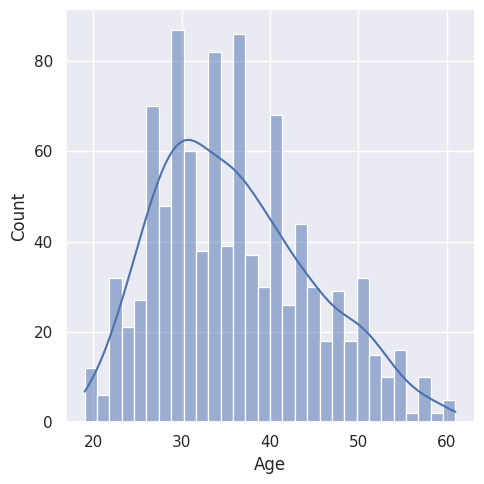

In [75]:
sns.displot(data=df, x='Age', bins=30, kde=True)

An almost normal distribution of this feature, ideal with models that make an normal distribution assumption (like Logistic Regression).

We pass to a jointplot showing **Area Income** versus **Age**, trying to find some correlation.

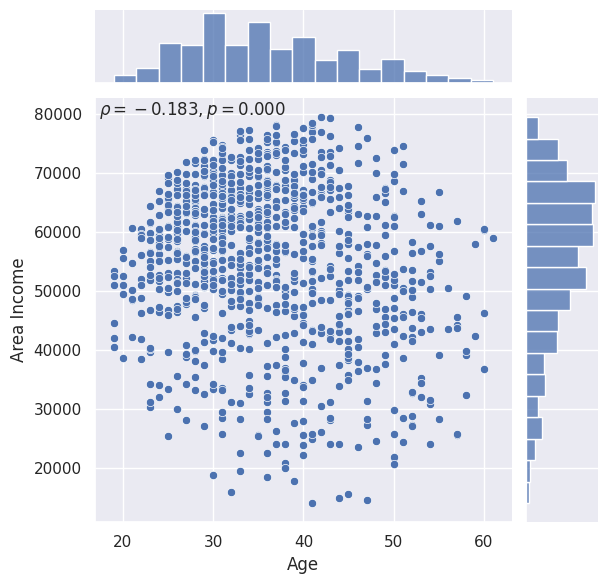

In [76]:
def annotCorr(df, x, y, plt, coord):
  r, p = stats.pearsonr(df[x], df[y])
  plt.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=coord, xycoords='axes fraction')

j = sns.jointplot(data=df, x='Age', y='Area Income')
annotCorr(df, 'Age', 'Area Income', j, (0.01, 0.96))
plt.show()

Judging from the plot above, there is no real correlazione between the people **Age** and the the **Area income** in clicking on ads.

Let's create a jointplot showing the kde distributions of **Daily Time spent on site** vs. **Age**, for the same purpose.

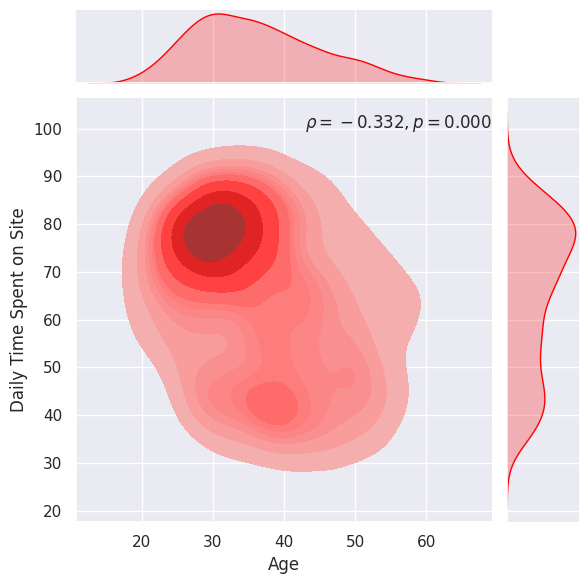

In [77]:
j = sns.jointplot(data=df, x='Age', y='Daily Time Spent on Site', kind='kde', color='red', fill='True')
annotCorr(df, 'Age', 'Daily Time Spent on Site',j, (0.55, 0.93))

In this case, instead, we have a little negative correlation. And this make sense, since usually younger people tends to pass more time online rather than older ones.

Now, we compare **Daily Time Spent on Site** and **Daily Internet Usage** always with a jointplot.

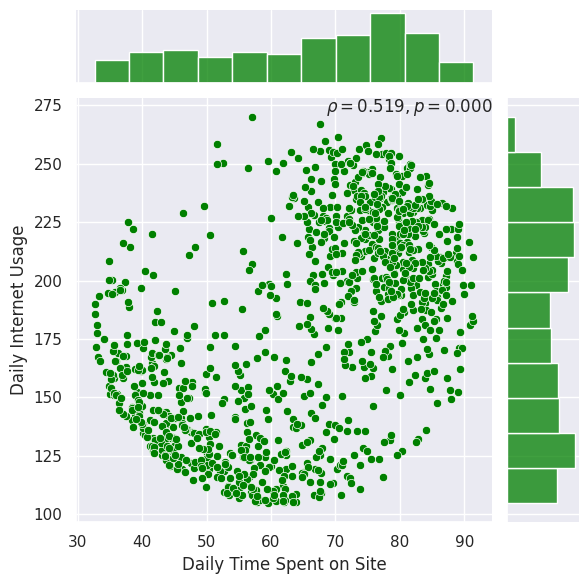

In [67]:
j = sns.jointplot(data=df, x='Daily Time Spent on Site', y='Daily Internet Usage', color='green')
annotCorr(df, 'Daily Time Spent on Site', 'Daily Internet Usage',j, (0.60, 0.967))

Finally, the jointplot above show a strong correlation between **Daily Time Spent on Site** and **Daily Internet Usage**. The reason, well, I think It's obvous.

To conclude the data visualization part, we create a pairplot with the hue defined by the **Clicked on Ad** column feature.

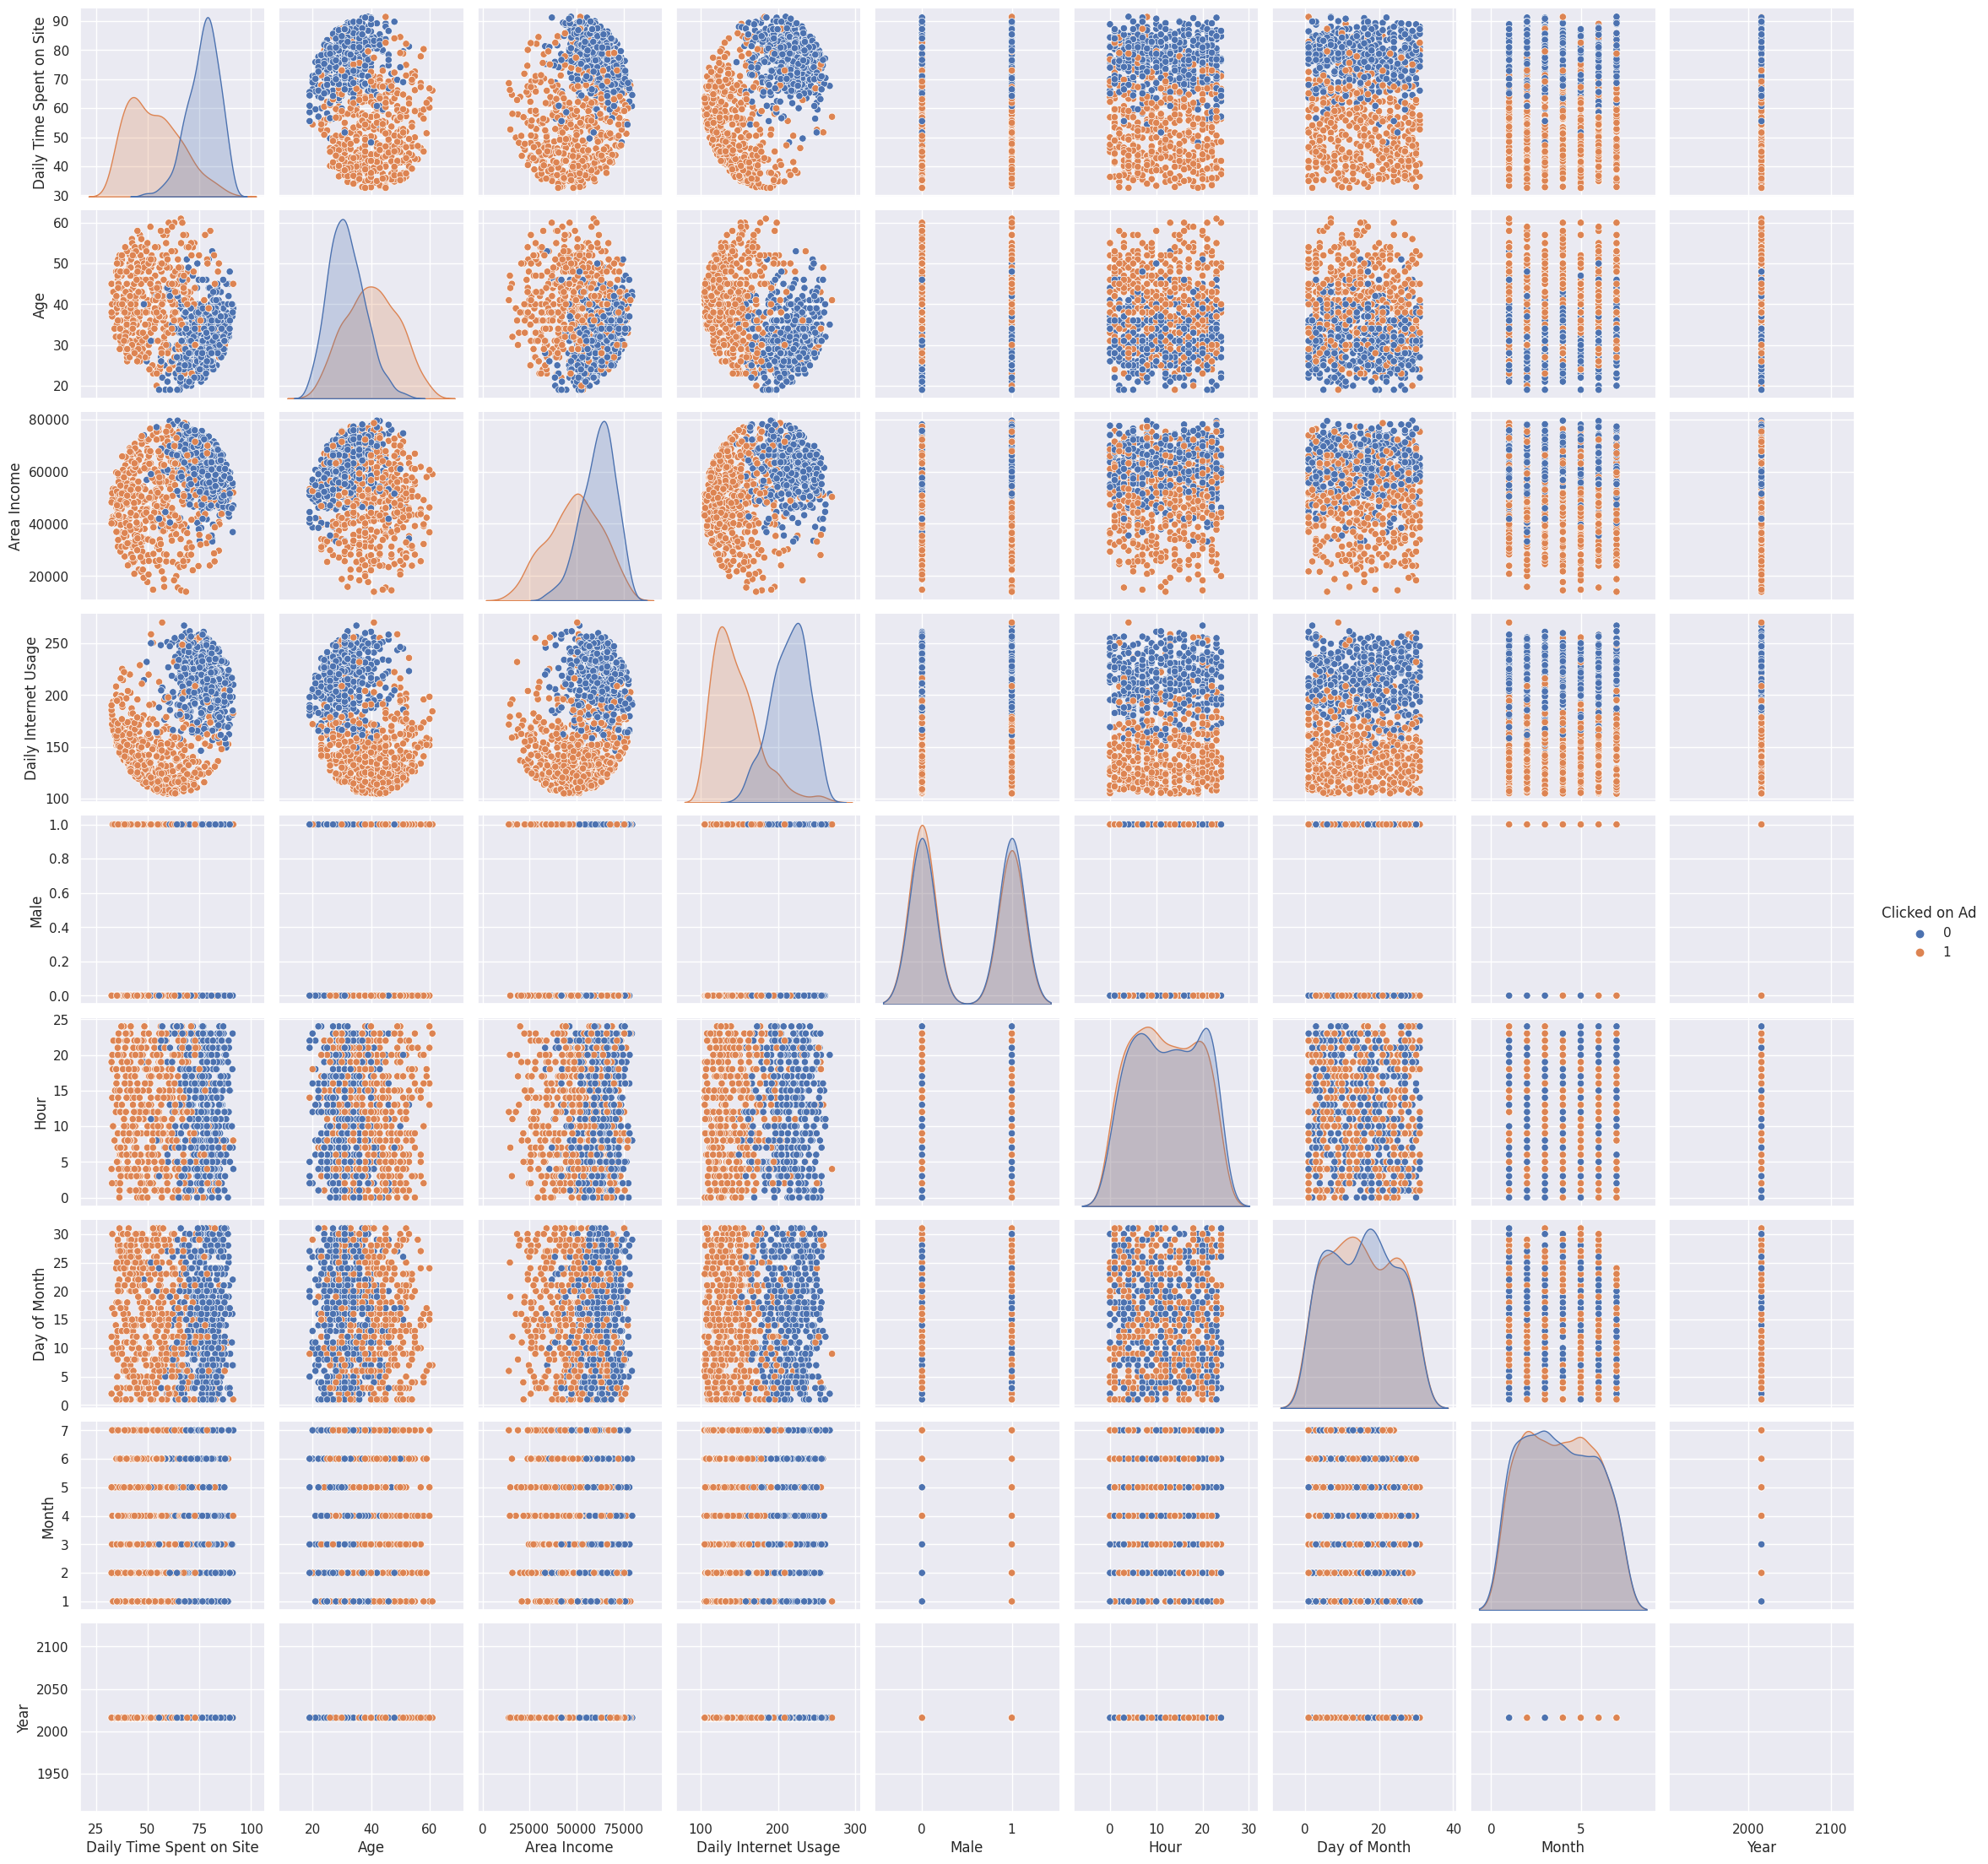

In [69]:
sns.pairplot(data=df, hue='Clicked on Ad')

## Logistic Regression

Now it's time to preprocess our data and use them to train our Logistic regression model and make prediction!

### Data Preprocessing

#### Handling NaN values

Let's review the missing values.

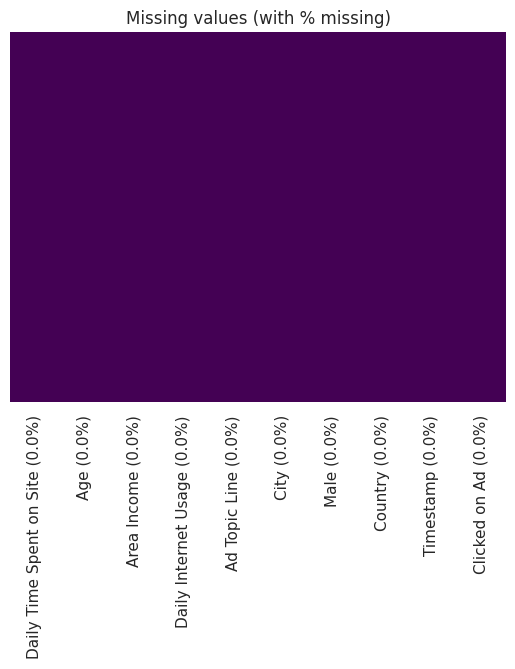

In [62]:
def rateMissing(c):
  return (round(len(df[df[c].isnull()])/len(df), 2))*100


ax = plt.axes()
sns.heatmap(df.isna(), xticklabels=df.columns.map(lambda l: '{lb} ({r}%)'.format(lb=l, r=rateMissing(l))),
            yticklabels=False, cbar=False, cmap='viridis', ax=ax)
ax.set_title('Missing values (with % missing)')
plt.show()


No Nan values to handle. So far, so good.

#### Categotical features handling

Let's plot for a moment the current situation of the dataset and column infos:

In [78]:
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 78.2+ KB


For this excercise we'll only take the numerical column, since the categorical ones are also not that necessary for our classification task.

In [80]:
dfp = df.select_dtypes(exclude=['object'])
dfp.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad
0,68.95,35,61833.90,256.09,0,0
1,80.23,31,68441.85,193.77,1,0
2,69.47,26,59785.94,236.50,0,0
3,74.15,29,54806.18,245.89,1,0
4,68.37,35,73889.99,225.58,0,0


#### Train/test dataset split

In [81]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    dfp.drop('Clicked on Ad', axis=1), dfp['Clicked on Ad'], test_size=.3)

#### Feature Scaling

Before training the model, the trainset and testset numerical features has to be scaled to a common numerical scale. Since the Logistic Regression is the ML model that we're going to use, we're going to apply a standardization of out data. This is ideal because model such as Logistic Regression take the Gaussian distribution assumption of our information.

In [82]:
from sklearn.preprocessing import StandardScaler

numr_features = ['Daily Time Spent on Site',
                 'Age', 'Area Income', 'Daily Internet Usage']

scaler = StandardScaler().fit(X_train[numr_features])

X_train[numr_features] = scaler.transform(X_train[numr_features])
X_test[numr_features] = scaler.transform(X_test[numr_features])

### The model

#### Model Training

Let's train and fit a logistic regression model on the training set.

In [84]:
from sklearn.linear_model import LogisticRegression

logmod = LogisticRegression()
logmod.fit(X_train, y_train)

LogisticRegression()

#### Prediction and Evaluation 

Now, time to predict some values with the testing data.

In [85]:
predictions = logmod.predict(X_test)

To evaluate the model performance based on the prediction, we'll use different metrics:
- the scikit-learn classification report
- a confusion matrix
- a ROC curve.

In [92]:
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay

In [89]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       160
           1       0.98      0.95      0.96       140

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



In [90]:
print(confusion_matrix(y_test, predictions))

[[157   3]
 [  7 133]]


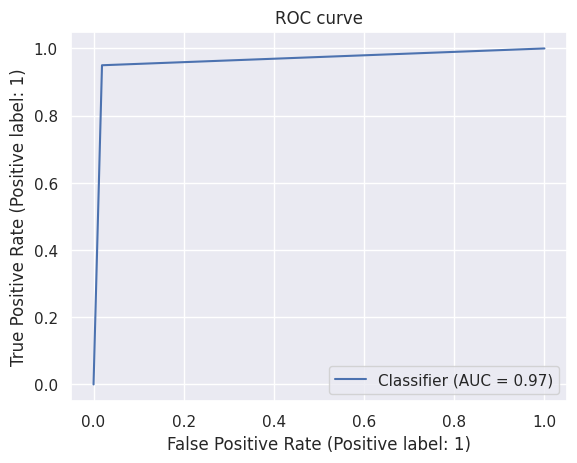

In [94]:
RocCurveDisplay.from_predictions(y_true=y_test, y_pred=predictions)
plt.title('ROC curve')
plt.show()

As we can notice from all the 3 metrics, we obtain excellent model result! In particular:
- the *classification report* shows a close-to perfect f1-score, so that means excellent performance in predicting both the class
- the *confusion matrix* shows a low number of both False Positive (FP) and False Negative (FN), resulting in high precision, recall and f1-score
- finally, the *ROC curve* illustrated that we are almost in the ROC heaven. That means almost perfect results in predictions.  